# <span style="color:blue">Project X4 </span>

### Оглавление

* [Вступление](#id_0)
  * [Оглавление](#id_1)
  * [Библиотеки](#id_1a)
  * [Папки с файлами](#id_1b)
  * [Необходимые функции](#id_1c)
* [Предобработка данных](#id_2)
  * [Создание списка нужных файлов](#id_2a)
  * [Нахождение информации в разных тегах XML на примере аргонского дестроера](#id_2b)
  * [Создание структуры тегов файла descriptions_eng](#id_2c)
  * [Создание общей таблицы характеристик кораблей по всем файлам](#id_2d)
  * [Создание выборки кораблей по назначению](#id_2e)
  * [Создание колонки с расами](#id_2f)
* [Аналитическая часть](#id_3)
  * [Рейтинг кораблей по массе](#id_3a)
  * [Рейтинг кораблей по параметру forward_drag](#id_3b)
  * [Рейтинг кораблей по прочности корпуса](#id_3c)

## Вступление <a class="anchor" id="id_0"></a> 

### Libraries <a class="anchor" id="id_1"></a> 

In [51]:
import pandas as pd
import os
import re
from bs4 import BeautifulSoup
import lxml
import matplotlib.pyplot as plt
import random
pd.set_option('display.max_columns', None)
import seaborn as sns
#pd.set_option('max_colwidth', 300)

### Описание <a class="anchor" id="id_1a"></a> 

X4: Foundations - космическая "песочница", в которой игрок может строить свои фабрики и верфи, торговать с другими расами, воевать и захватывать корабли и выполнять масштабные сюжетные кампании в динамичном и развивающемся космосе с красивой графикой и эффектами. Игра была разработана кампанией Egosoft в 2018 году и к настоящему моменту имеет 4 дополнения.

### Папки с файлами <a class="anchor" id="id_1b"></a> 

*units_folder* - каталог с файлами xml, которых сохранена информация о игровых объектах.  
*descriptions* - файл, в котором закодирована вся текстовая инофрмация

In [52]:
units_folder = r'E:\Steam\X4\Unpacked\assets\units'
#descriptions in english
descriptions_eng = r'E:\Steam\X4\Unpacked\t\0001-l044.xml'
#descriptions in russian
descriptions_ru = r'E:\Steam\X4\Unpacked\t\0001-l007.xml'

### Необходимые функции <a class="anchor" id="id_1c"></a> 

In [53]:
#функция для выравнивания списков
def flatten(l):
    return [item for sublist in l for item in sublist]

In [54]:
# Функция для вывода пропущенных значений в датафрейме, просто вызовите ее, указав нужный датафрейм в параметрах
def missing_values_tab(df):
    #Подсчет количества пропущенных значений
    mis_val = df.isnull().sum()
    #Подсчет доли пропущенных значений в колонке в процентах
    mis_val_percent = round(100 * df.isnull().sum() / len(df),2)
    #Объединяем две созданных колонки в один датафрейм с параметром axis=1, чтобы добавить их справа-слева
    mv_table = pd.concat([mis_val, mis_val_percent], axis=1)  
    #Переименование колонок
    mv_table = mv_table.rename(columns = {0 : 'Пропущенные значения', 1 : '% от всех значений'})
    #Создаем колонку с типом данных 
    mv_table['Тип данных'] = df.dtypes
    mv_table = mv_table[mv_table.iloc[:,1]!=0].sort_values(by='Пропущенные значения',ascending=False)
    print ("Ваш датафрейм содержит " + str(df.shape[1]) + " колонок и " + str(df.shape[0]) + " строк.\n")
    print("Он имеет  " + str(mv_table.shape[0]) +" колонок с пропущенными значениями.")    
    return display(mv_table) 

## Предобработка данных

### Создание списка нужных файлов <a class="anchor" id="id_2a"></a> 

- list_of_files - cписок имен файлов XML с путями
- list_of_XMLfiles  - cписок имен файлов

In [55]:
list_of_files = []
list_of_XMLfiles = []

for root, dirs, files in os.walk(units_folder):
    for file in files:
        if file.endswith(".xml"):
            list_of_XMLfiles.append( file)
            #print(os.path.join(root, file))
            list_of_files.append(os.path.join(root, file))
        

In [56]:
#print(list_of_files) 
#print('Список каталогов в units_folder: ', os.listdir(units_folder))

### Нахождение информации в разных тегах XML на примере аргонского дестроера <a class="anchor" id="id_2b"></a> 

In [57]:
keyword = 'ship_arg_l_destroyer_01'
arg_destroyer_files = []
for file in list_of_files :
    if keyword in file:
        print(file)
        arg_destroyer_files.append(file)
    

E:\Steam\X4\Unpacked\assets\units\size_l\ship_arg_l_destroyer_01.xml
E:\Steam\X4\Unpacked\assets\units\size_l\macros\ship_arg_l_destroyer_01_a_macro.xml
E:\Steam\X4\Unpacked\assets\units\size_l\macros\ship_arg_l_destroyer_01_b_macro.xml


In [58]:
with open(arg_destroyer_files[1], 'r') as user_file:
    file_contents = user_file.read()
#Создание древовидной структуры файла      
arg_destroyer_01a_soup = BeautifulSoup(file_contents, features="xml")

Нужные теги: 
```
<explosiondamage shield="5000" value="1000"/>
<storage missile="160" unit="10"/>
<hull max="93000"/>
<secrecy level="2"/>
<purpose primary="fight"/>
<people capacity="44"/>
<shipdetail ref="shipdetail_ship_l_01"/>
<physics mass="196.016">
<inertia pitch="96.271" roll="77.016" yaw="96.271"/>
<drag forward="99.004" horizontal="73.005" pitch="106.203" reverse="396.016" roll="106.203" vertical="73.005" yaw="106.203"/>
</physics>
<thruster tags="large"/>
<ship type="destroyer"/>
</properties> 
``` 
- Оборудование 
```
<software>
<software compatible="1" ware="software_dockmk2"/>
<software default="1" ware="software_flightassistmk1"/>
<software default="1" ware="software_scannerlongrangemk1"/>
<software compatible="1" ware="software_scannerlongrangemk2"/>
<software default="1" ware="software_scannerobjectmk1"/>
<software compatible="1" ware="software_scannerobjectmk2"/>
<software default="1" ware="software_targetmk1"/>
<software compatible="1" ware="software_trademk1"/>
</software> 
```

Теги, необходимые для включения в таблицу:

<span style = "color:red">выборку по расам сделать и добавить колонку с именем xml файла, в котором характеристики корабля
</span>

Раса будет браться из имени xml файла:
arg - Argon, tel - Teladi, par = Paranid etc

In [59]:
needed_tags = ['macro', 'explosiondamage', 'storage', 'hull', 'secrecy', 'purpose', 'people', 'physics', 'inertia', 'drag', 'ship']

In [60]:
list_of_tags_in_macroFiles = []
for tag in arg_destroyer_01a_soup.findAll():
    #print(tag.name)
    list_of_tags_in_macroFiles.append(tag)

In [61]:
#list_of_tags_in_macroFiles

In [62]:
#Find filename of ship_data
macro_tag = arg_destroyer_01a_soup.find('macro')
filename = macro_tag['name']+'.xml'
print(filename)

ship_arg_l_destroyer_01_a_macro.xml


In [63]:
#Нахождение тега типа корабля
ship_type = arg_destroyer_01a_soup.find('ship').attrs
print(ship_type['type'])            
    

destroyer


In [64]:
hull_max_size = arg_destroyer_01a_soup.find('hull')
print(hull_max_size)

<hull max="93000"/>


Нахождение значений аттрибутов внутри тега:

In [65]:
for tag in  arg_destroyer_01a_soup.findAll('storage'):
    print(tag['missile'])
    print(tag['unit'])
#Another way to extract values
print(arg_destroyer_01a_soup.findAll('storage')[0]['missile'])
print(arg_destroyer_01a_soup.findAll('storage')[0]['unit'])


160
10
160
10


In [66]:
tag_values_list = []
for tag in needed_tags:
    #if tag != 'macro':
        tag_values = arg_destroyer_01a_soup.find(tag).attrs.values()
        tag_values_list.append(list(tag_values))
    #else:
        #filename = arg_destroyer_01a_soup.find('macro')['name']+'.xml'
        #tag_values_list.append(filename)
print(tag_values_list)

[['ship_arg_l_destroyer_01_a_macro', 'ship_l'], ['1000', '5000'], ['160', '10'], ['93000'], ['2'], ['fight'], ['44'], ['196.016'], ['96.271', '96.271', '77.016'], ['99.004', '396.016', '73.005', '73.005', '106.203', '106.203', '106.203'], ['destroyer']]


In [67]:
print(type(arg_destroyer_01a_soup.findAll('storage')))
storage = arg_destroyer_01a_soup.find('storage')
print(type(storage))
print(type(storage.attrs))
#find attribute names
print(storage.attrs.keys())
#find attribute values
print(storage.attrs.values())


<class 'bs4.element.ResultSet'>
<class 'bs4.element.Tag'>
<class 'dict'>
dict_keys(['missile', 'unit'])
dict_values(['160', '10'])


Результат findAll - тип ResultSet    
Результат find() - тип Tag  
Результат tag.attrs - тип dict   

In [68]:
storage = arg_destroyer_01a_soup.find('storage')
type(storage.attrs)
print(storage.attrs.keys())

dict_keys(['missile', 'unit'])


Find all attributes:

!!!Repair

In [69]:
#List of ship characteristics
tag_names_list = []
for tag in arg_destroyer_01a_soup.findAll(): 
    if tag.name =='macro' and 'name' in tag.attrs: # because of additional macro tags with unwanted attributes
         D = {}
         D[tag.name] = list(tag.attrs.keys())
         tag_names_list.append(D)
         #tag_names_list.append()
    else:         
         if tag.name in needed_tags and len(tag.attrs) > 1 and tag.name !='macro':
              D = {}
              D[tag.name] = list(tag.attrs.keys())
              tag_names_list.append(D)
         elif tag.name in needed_tags and len(tag.attrs) == 1 and tag.name !='macro':                
               tag_names_list.append(tag.name)
         #print(tag.name)      

print(tag_names_list)
        

[{'macro': ['name', 'class']}, {'explosiondamage': ['value', 'shield']}, {'storage': ['missile', 'unit']}, 'hull', 'secrecy', 'purpose', 'people', 'physics', {'inertia': ['pitch', 'yaw', 'roll']}, {'drag': ['forward', 'reverse', 'horizontal', 'vertical', 'pitch', 'yaw', 'roll']}, 'ship']


In [70]:
#tag_names_list = tag_names_list[1:]+tag_names_list[:1]
#print(tag_names_list)
#print(tag_values_list)
temp = []
#count=0
for count in range(len(tag_names_list)):   
   if isinstance(tag_names_list[count], dict):       
       for key in tag_names_list[count]:
           D = {}
           D[key] = tag_values_list[count]
           temp.append(D)
   else:   
    
        temp.append(tag_values_list[count])          
print(len(temp))
print(len(tag_names_list))
tag_values_dict = temp

11
11


In [71]:
#List of ship characteristics
tag_names_dict = []
ship_data = {}
for tag in arg_destroyer_01a_soup.findAll():    
    if tag.name in needed_tags and not'ref' in tag.attrs:
        #print(tag.name, tag.attrs)
        D = dict(zip(tag.name, tag.attrs))
        ship_data[tag.name] = tag.attrs
print(ship_data)

        

{'macro': {'name': 'ship_arg_l_destroyer_01_a_macro', 'class': 'ship_l'}, 'explosiondamage': {'value': '1000', 'shield': '5000'}, 'storage': {'missile': '160', 'unit': '10'}, 'hull': {'max': '93000'}, 'secrecy': {'level': '2'}, 'purpose': {'primary': 'fight'}, 'people': {'capacity': '44'}, 'physics': {'mass': '196.016'}, 'inertia': {'pitch': '96.271', 'yaw': '96.271', 'roll': '77.016'}, 'drag': {'forward': '99.004', 'reverse': '396.016', 'horizontal': '73.005', 'vertical': '73.005', 'pitch': '106.203', 'yaw': '106.203', 'roll': '106.203'}, 'ship': {'type': 'destroyer'}}


### # Нахождение значений page_id и ship_name id:

In [72]:
# Нахождение значений page_id и ship_name id:
for tag in arg_destroyer_01a_soup.findAll('identification'):
    name_string = tag.attrs['name']
    page_id = re.findall('\d+',name_string)[0]
    name_id = re.findall('\d+',name_string)[1]
        #list_of_tags_in_macroFiles.append(tag)
print('ID атрибута page {0}, ID атрибута названия корабля {1}'.format(page_id, name_id))

temp_dict = {}
for file in arg_destroyer_files:
    with open(file, 'r') as user_file:
        file_contents = user_file.read()
        #Создание древовидной структуры файла      
        file_BStree = BeautifulSoup(file_contents, features="xml")
        for tag in file_BStree.findAll('identification'):
            name_string = tag.attrs['name']
            page_id = re.findall('\d+',name_string)[0]
            name_id = re.findall('\d+',name_string)[1]
            temp_dict['pageID'] = page_id
            temp_dict['nameID'] = name_id
print(temp_dict)

ID атрибута page 20101, ID атрибута названия корабля 11002
{'pageID': '20101', 'nameID': '11003'}


Варианты колонок для таблицы:

In [73]:
columns1 = pd.MultiIndex.from_arrays([['explosiondamage','explosiondamage', 'storage', 'storage', 'hull','secrecy', 'purpose','people','physics',
                                      'inertia', 'inertia','inertia', 'drag','drag','drag','drag','drag','drag','drag'],
                                     ['value','shield','missile','unit','hull','secrecy','purpose','people','physics',
                                      'pitch','yaw','roll','forward','reverse','horizontal', 'vertical', 'pitch', 'yaw', 'roll']], names=['group', 'stat'])

example1 = pd.DataFrame(columns = columns1)
display(example1)

Empty DataFrame
Columns: [(explosiondamage, value), (explosiondamage, shield), (storage, missile), (storage, unit), (hull, hull), (secrecy, secrecy), (purpose, purpose), (people, people), (physics, physics), (inertia, pitch), (inertia, yaw), (inertia, roll), (drag, forward), (drag, reverse), (drag, horizontal), (drag, vertical), (drag, pitch), (drag, yaw), (drag, roll)]
Index: []

In [74]:
columns2 = pd.MultiIndex.from_arrays([['explosiondamage','explosiondamage', 'storage', 'storage', '','', '','','',
                                      'inertia', 'inertia','inertia', 'drag','drag','drag','drag','drag','drag','drag','type'],
                                     ['value','shield','missile','unit','hull','secrecy','purpose','people','physics',
                                      'pitch','yaw','roll','forward','reverse','horizontal', 'vertical', 'pitch', 'yaw', 'roll','']], names=['group', 'stat'])
example2 = pd.DataFrame(columns = columns2)
display(example2)

Empty DataFrame
Columns: [(explosiondamage, value), (explosiondamage, shield), (storage, missile), (storage, unit), (, hull), (, secrecy), (, purpose), (, people), (, physics), (inertia, pitch), (inertia, yaw), (inertia, roll), (drag, forward), (drag, reverse), (drag, horizontal), (drag, vertical), (drag, pitch), (drag, yaw), (drag, roll), (type, )]
Index: []

In [75]:
columns3 = pd.MultiIndex.from_arrays([['explosiondamage','explosiondamage', 'storage', 'storage', 'hull','secrecy', 'purpose','people','physics',
                                      'inertia', 'inertia','inertia', 'drag','drag','drag','drag','drag','drag','drag','ship','meta','meta'],
                                     ['value','shield','missile','unit','','','','','',
                                      'pitch','yaw','roll','forward','reverse','horizontal', 'vertical', 'pitch', 'yaw', 'roll','type','filename','class']], names=['group', 'stat'])
example3 = pd.DataFrame(columns = columns3)
display(example3)

Empty DataFrame
Columns: [(explosiondamage, value), (explosiondamage, shield), (storage, missile), (storage, unit), (hull, ), (secrecy, ), (purpose, ), (people, ), (physics, ), (inertia, pitch), (inertia, yaw), (inertia, roll), (drag, forward), (drag, reverse), (drag, horizontal), (drag, vertical), (drag, pitch), (drag, yaw), (drag, roll), (ship, type), (meta, filename), (meta, class)]
Index: []

Создание списка путей к конфигурационным файлам кораблей

In [76]:
list_of_ships = []
keywords = ['ship','macro']
for file in list_of_files:
    if keywords[0] in file and keywords[1] in file:
        list_of_ships.append(file)  
print(len(list_of_ships))     

297


### Создание структуры тегов файла descriptions_eng <a class="anchor" id="id_2c"></a>

```<macros>
  <macro name="ship_tel_xl_builder_01_a_macro" class="ship_xl">
    <component ref="ship_arg_xl_builder_01" />
    <properties>
      <identification name="{20101,21102}" basename="{20101,21101}" description="{20101,21112}" variation="{20111,1101}" shortvariation="{20111,1103}" icon="ship_xl_build_01" />      
      <explosiondamage value="1200" shield="6000" />
      <storage missile="40" unit="100" />
      <hull max="115000" />
      <secrecy level="1" />
      <purpose primary="build" />
      <people capacity="219" />
      <physics mass="984.137">
        <inertia pitch="612.235" yaw="612.235" roll="489.788" />
        <drag forward="276.827" reverse="1107.31" horizontal="519.018" vertical="519.018" pitch="896.827" yaw="896.827" roll="896.827" />
      </physics>```

0001-l044.xml - словарь имен и описаний на английском языке.
Например, раздел  
```<page id="20101" title="Ships" descr="Names and descriptions of ships" voice="yes"> ```  
    отвечает за названия кораблей по типу {pade_id, ship_id}. Например, корабль Albatros Vanguard имеет имя в виде name="{20101,21102}:

```<identification name="{20101,21102}" basename="{20101,21101}" description="{20101,21112}" variation="{20111,1101}" shortvariation="{20111,1103}" icon="ship_xl_build_01" />```   

Имя в файле с текстом:  
```<t id="21101">Albatross</t>```</br>
```<t id="21102">(Albatross Vanguard){20101,21101} {20111,1101}</t>```

In [77]:
with open(descriptions_eng, 'r') as user_file:
    file_contents = user_file.read()
#Создание древовидной структуры файла      
descriptions_Sobject = BeautifulSoup(file_contents, features="xml")

list_of_tags_in_textfile = []
for tag in descriptions_Sobject.findAll('page', attrs = {'id':20101,'title':'Ships','descr':'Names and descriptions of ships'}):
    #print(tag.name)
    list_of_tags_in_textfile.append(tag)

<span style = "color:red">Не удалять, надо для запросов по id</span>:

In [78]:
##find name
ex = descriptions_Sobject.find('t', attrs = {'id':11503})
#type(ex.contents)
name = re.search('[A-Za-z ]+',ex.text).group()
name

'Click on ASSIGN BUILDER SHIP'

### Создание общей таблицы характеристик кораблей по всем файлам <a class="anchor" id="id_2d"></a>

In [79]:
## КОПИЯ НЕ УДАЛЯТЬ
temp = [] # Временный список, куда будут присоединяться отдельные списки для каждого корабля
text_ids_list = [] # список словарей значений page_id и name_id

for file in list_of_ships:
    ship_data = {} 
    with open(file, 'r') as user_file:
        file_contents = user_file.read()
        #Создание древовидной структуры файла      
        file_BStree = BeautifulSoup(file_contents, features="xml")        
        
       
        for tag in file_BStree.findAll(): 
              
            if tag.name in needed_tags and not'ref' in tag.attrs:
             #print(tag.name, tag.attrs)
                D = dict(zip(tag.name, tag.attrs))
                ship_data[tag.name] = tag.attrs
        temp.append(ship_data)       
        ## Create list of names
        for tag in file_BStree.findAll('identification'):
            D = {}
            name_string = tag.attrs['name']
            page_id = re.findall('\d+',name_string)[0]
            name_id = re.findall('\d+',name_string)[1]
            D['pageID'] = page_id
            D['nameID'] = name_id
            text_ids_list.append(D)

## Checking for errors:
if len(temp) == len(text_ids_list):
    print('Вроде хорошо')
else:
    print('Длины списков не равны')

Вроде хорошо


In [80]:
for ele in temp[:1]:
    print(ele)

{'macro': {'name': 'ship_arg_l_destroyer_01_a_macro', 'class': 'ship_l'}, 'explosiondamage': {'value': '1000', 'shield': '5000'}, 'storage': {'missile': '160', 'unit': '10'}, 'hull': {'max': '93000'}, 'secrecy': {'level': '2'}, 'purpose': {'primary': 'fight'}, 'people': {'capacity': '44'}, 'physics': {'mass': '196.016'}, 'inertia': {'pitch': '96.271', 'yaw': '96.271', 'roll': '77.016'}, 'drag': {'forward': '99.004', 'reverse': '396.016', 'horizontal': '73.005', 'vertical': '73.005', 'pitch': '106.203', 'yaw': '106.203', 'roll': '106.203'}, 'ship': {'type': 'destroyer'}}


In [81]:
columns4 = pd.MultiIndex.from_arrays([['macro',"macro", 'explosiondamage','explosiondamage', 'storage', 'storage', 'hull','secrecy', 'purpose','people','physics',
                                      'inertia', 'inertia','inertia', 'drag','drag','drag','drag','drag','drag','drag','ship'],
                                     ["name", "class ",  'value','shield','missile','unit','','','','','',
                                      'pitch','yaw','roll','forward','reverse','horizontal', 'vertical', 'pitch', 'yaw', 'roll','type']], names=['group', 'stat'])
example4 = pd.DataFrame(columns = columns4)
display(example4)

Empty DataFrame
Columns: [(macro, name), (macro, class ), (explosiondamage, value), (explosiondamage, shield), (storage, missile), (storage, unit), (hull, ), (secrecy, ), (purpose, ), (people, ), (physics, ), (inertia, pitch), (inertia, yaw), (inertia, roll), (drag, forward), (drag, reverse), (drag, horizontal), (drag, vertical), (drag, pitch), (drag, yaw), (drag, roll), (ship, type)]
Index: []

temp = [] # Временный список, куда будут присоединяться отдельные списки для каждого корабля
text_ids_list = [] # список словарей значений page_id и name_id

for file in list_of_ships:
    with open(file, 'r') as user_file:
        file_contents = user_file.read()
        #Создание древовидной структуры файла      
        file_BStree = BeautifulSoup(file_contents, features="xml")
        
        ##Create list of stats 
        tag_names_list = []
        for tag in file_BStree.findAll():    
            if tag.name in needed_tags and len(tag.attrs) > 1:
                D = {}
                D[tag.name] = list(tag.attrs.keys())
                tag_names_list.append(D)
            elif tag.name in needed_tags and len(tag.attrs) == 1:   
                tag_names_list.append(tag.name)
        
        ## Create list of ship values:
        tag_values_list = []
        for tag in tag_names_list:
            tag_values = file_BStree.find(tag).attrs.values()
            tag_values_list.append(list(tag_values))
        tag_values_list = flatten(tag_values_list)          
        temp.append(tag_values_list)
        
        ## Create list of names
        for tag in file_BStree.findAll('identification'):
            D = {}
            name_string = tag.attrs['name']
            page_id = re.findall('\d+',name_string)[0]
            name_id = re.findall('\d+',name_string)[1]
            D['pageID'] = page_id
            D['nameID'] = name_id
            text_ids_list.append(D)

## Checking for errors:
if len(temp) == len(text_ids_list):
    print('Вроде хорошо')
else:
    print('Длины списков не равны')
    
    
    

In [82]:
ship_names = []
names_ids_list =  []
for element in text_ids_list:
    ex = descriptions_Sobject.find('t', attrs = {'id':element['nameID']})
    name = re.search('[A-Za-z ]+',ex.text).group()
    ship_names.append(name)
    names_ids_list.append(element['nameID'])

In [83]:
## Creating table    
ship_data = pd.DataFrame.from_dict(temp)
# Выбор стиля названий колонок
#ship_data.columns = columns4 
display(ship_data.head(2))

,macro,explosiondamage,storage,hull,secrecy,purpose,people,physics,inertia,drag,ship
0,"{'name': 'ship_arg_l_destroyer_01_a_macro', 'c...","{'value': '1000', 'shield': '5000'}","{'missile': '160', 'unit': '10'}",{'max': '93000'},{'level': '2'},{'primary': 'fight'},{'capacity': '44'},{'mass': '196.016'},"{'pitch': '96.271', 'yaw': '96.271', 'roll': '...","{'forward': '99.004', 'reverse': '396.016', 'h...",{'type': 'destroyer'}
1,"{'name': 'ship_arg_l_destroyer_01_b_macro', 'c...","{'value': '1000', 'shield': '5000'}","{'missile': '160', 'unit': '10'}",{'max': '111000'},{'level': '2'},{'primary': 'fight'},{'capacity': '36'},{'mass': '235.22'},"{'pitch': '103.378', 'yaw': '103.378', 'roll':...","{'forward': '108.805', 'reverse': '435.22', 'h...",{'type': 'destroyer'}


In [84]:
columns_to_expand = ['macro', 'explosiondamage',	'storage',	'hull',	 'secrecy',	'purpose',	'people',	'physics',	'inertia',	'drag','ship'	]
for column in columns_to_expand:
    ship_data = pd.concat([ship_data.drop([column], axis = 1), ship_data[column].apply(pd.Series)], axis = 1)   

In [85]:
ship_data = ship_data.drop(['alias',0,'time','countermeasure'],axis = 1)
display(ship_data.head(2))

,name,class,value,shield,missile,unit,max,level,primary,capacity,mass,pitch,yaw,roll,forward,reverse,horizontal,vertical,pitch,yaw,roll,type
0,ship_arg_l_destroyer_01_a_macro,ship_l,1000,5000,160,10,93000,2,fight,44,196.016,96.271,96.271,77.016,99.004,396.016,73.005,73.005,106.203,106.203,106.203,destroyer
1,ship_arg_l_destroyer_01_b_macro,ship_l,1000,5000,160,10,111000,2,fight,36,235.22,103.378,103.378,82.702,108.805,435.22,87.605,87.605,114.044,114.044,114.044,destroyer


Переименование колонок

In [86]:
column_names = ['filename','ship_class','explosiondamage_value',
                'explosiondamage_shield','storage_missile','storage_unit','hull',
                'secrecy_level','purpose','people_capacity','ship_mass',
                'inertia_pitch', 'inertia_yaw', 'inertia_roll',
                'drag_forward', 'drag_reverse', 'drag_horizontal','drag_vertical',
                'drag_pitch','drag_yaw', 'drag_roll', 'ship_type']
ship_data.columns = column_names

ship_data_new = ship_data_new.rename (columns={'name':'filename','primary':'purpose','level':'security_level'})

Добавление колонки с именем корабля

In [87]:
# Make merge only if lists are of equal lenth
if len(ship_data) == len(ship_names):
    ship_data['name'] = ship_names
    #Do some rearranging of columns' order
    cols = ship_data.columns.to_list()
    cols = cols[-1:] + cols[:-1]
    ship_data_new = ship_data[cols]
else:
    print('Длины не равны')

Добавление ID имени корабля

In [88]:
ship_data['name_id'] = names_ids_list

Создание копии таблицы

In [89]:
#Make a save copy of the table
saveCopy_df = ship_data.copy(deep = True)

 <span style="color:yellow">Основная таблица </span>

In [90]:
display(ship_data.head())
print(ship_data.info())

,filename,ship_class,explosiondamage_value,explosiondamage_shield,storage_missile,storage_unit,hull,secrecy_level,purpose,people_capacity,ship_mass,inertia_pitch,inertia_yaw,inertia_roll,drag_forward,drag_reverse,drag_horizontal,drag_vertical,drag_pitch,drag_yaw,drag_roll,ship_type,name,name_id
0,ship_arg_l_destroyer_01_a_macro,ship_l,1000,5000,160,10,93000,2,fight,44,196.016,96.271,96.271,77.016,99.004,396.016,73.005,73.005,106.203,106.203,106.203,destroyer,L Ship,11002
1,ship_arg_l_destroyer_01_b_macro,ship_l,1000,5000,160,10,111000,2,fight,36,235.22,103.378,103.378,82.702,108.805,435.22,87.605,87.605,114.044,114.044,114.044,destroyer,XL Ship,11003
2,ship_arg_l_miner_liquid_01_a_macro,ship_l,800,4000,30,10,26000,1,mine,46,205.27,133.749,133.749,106.999,56.738,324.216,126.666,126.666,140.897,140.897,140.897,largeminer,You cannot give orders to a station,11104
3,ship_arg_l_miner_liquid_01_b_macro,ship_l,800,4000,30,10,32000,1,mine,38,246.324,147.778,147.778,118.223,62.485,357.059,151.999,151.999,155.677,155.677,155.677,largeminer,s,11105
4,ship_arg_l_miner_solid_01_a_macro,ship_l,800,4000,30,10,26000,1,mine,46,204.245,132.733,132.733,106.186,56.594,323.396,127.239,127.239,140.528,140.528,140.528,largeminer,Disarm turrets,11102


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   filename                297 non-null    object
 1   ship_class              297 non-null    object
 2   explosiondamage_value   151 non-null    object
 3   explosiondamage_shield  147 non-null    object
 4   storage_missile         211 non-null    object
 5   storage_unit            98 non-null     object
 6   hull                    297 non-null    object
 7   secrecy_level           289 non-null    object
 8   purpose                 291 non-null    object
 9   people_capacity         222 non-null    object
 10  ship_mass               297 non-null    object
 11  inertia_pitch           296 non-null    object
 12  inertia_yaw             296 non-null    object
 13  inertia_roll            296 non-null    object
 14  drag_forward            297 non-null    object
 15  drag_r

### Изменение типов колонок

In [91]:
cols_to_float = ['ship_mass',	'inertia_pitch',	'inertia_yaw',	'inertia_roll',	'drag_forward',
                 'drag_reverse',	'drag_horizontal',	'drag_vertical',	'drag_pitch',	'drag_yaw',	'drag_roll'	]
try:
    for column in cols_to_float:
        ship_data[column] = ship_data[column].astype('float')
except BaseException:
    print(column)

Пропуски в данных заменю нулями:

In [92]:
cols_to_int = ['explosiondamage_value',	'explosiondamage_shield',	'storage_missile',
               'storage_unit',	'hull',	'secrecy_level', 'people_capacity']
try:
    for column in cols_to_int:
        ship_data[column] = ship_data[column].fillna(0)
        ship_data[column] = ship_data[column].astype('int')
except BaseException:
    print(column)

In [93]:
ship_data['purpose'] = ship_data['purpose'].fillna('unknown')
ship_data['ship_type'] = ship_data['ship_type'].fillna('unknown')

In [94]:
display(ship_data[ship_data.isna().any(axis = 1)])

,filename,ship_class,explosiondamage_value,explosiondamage_shield,storage_missile,storage_unit,hull,secrecy_level,purpose,people_capacity,ship_mass,inertia_pitch,inertia_yaw,inertia_roll,drag_forward,drag_reverse,drag_horizontal,drag_vertical,drag_pitch,drag_yaw,drag_roll,ship_type,name,name_id
289,ship_ter_xs_police_01_a_macro,ship_xs,0,0,0,0,300,2,unknown,0,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,police,Terran Station Security Vessel,111001


### Создание выборки кораблей по назначению <a class="anchor" id="id_2e"></a>

In [95]:
purposes = ['fight', 'mine', 'trade', 'dismantling', 'salvage' ,'build', 'auxiliary']
fight_ships = ship_data[ship_data["purpose"]=="fight"]
mine_ships = ship_data[ship_data["purpose"]=="mine"]
trade_ships = ship_data[ship_data["purpose"]=="trade"]
builders = ship_data[ship_data["purpose"]=="build"]
auxiliary_ships = ship_data[ship_data["purpose"]=="auxiliary"]
dismantling_ships = ship_data[ship_data["purpose"]=='dismantling']
salvage_ships = ship_data[ship_data["purpose"]=='salvage']
dfs_list = [fight_ships, mine_ships, trade_ships, builders, auxiliary_ships, dismantling_ships, salvage_ships]
all_ships = pd.DataFrame()
for df in dfs_list:
    all_ships = pd.concat([all_ships, df], axis = 0)

#### Работа по дубликатам и аномалиям

In [96]:
display(all_ships.head())

,filename,ship_class,explosiondamage_value,explosiondamage_shield,storage_missile,storage_unit,hull,secrecy_level,purpose,people_capacity,ship_mass,inertia_pitch,inertia_yaw,inertia_roll,drag_forward,drag_reverse,drag_horizontal,drag_vertical,drag_pitch,drag_yaw,drag_roll,ship_type,name,name_id
0,ship_arg_l_destroyer_01_a_macro,ship_l,1000,5000,160,10,93000,2,fight,44,196.016,96.271,96.271,77.016,99.004,396.016,73.005,73.005,106.203,106.203,106.203,destroyer,L Ship,11002
1,ship_arg_l_destroyer_01_b_macro,ship_l,1000,5000,160,10,111000,2,fight,36,235.220,103.378,103.378,82.702,108.805,435.220,87.605,87.605,114.044,114.044,114.044,destroyer,XL Ship,11003
16,ship_atf_l_destroyer_01_a_macro,ship_l,1000,5000,160,10,119000,3,fight,187,124.088,107.528,107.528,86.022,48.613,194.453,23.482,23.482,91.818,91.818,91.818,destroyer,Syn,66901
17,ship_par_l_destroyer_01_a_macro,ship_l,1000,5000,160,10,99000,3,fight,47,209.751,105.680,105.680,84.544,76.828,307.313,68.897,68.897,108.950,108.950,108.950,destroyer,Odysseus Vanguard,30702
18,ship_par_l_destroyer_01_b_macro,ship_l,1000,5000,160,10,119000,3,fight,39,251.701,113.818,113.818,91.055,84.694,338.776,82.676,82.676,117.340,117.340,117.340,destroyer,Odysseus Sentinel,30703


### Создание колонки с расами <a class="anchor" id="id_2f"></a>

In [97]:
def calculate_race(data):
    if re.match('\D+_tel_\D+', data):
        return "teladi"
    if re.match('\D+_arg_\D+', data):
        return "argon"
    if re.match('\D+_par_\D+', data):
        return "paranid"
    if re.match('\D+_ter_\D+', data):
        return "terran"
    if re.match('\D+_spl_\D+', data):
        return "split"
    if re.match('\D+_pir_\D+', data):
        return "pirate"
    if re.match('\D+_xen_\D+', data):
        return "xenons"
    if re.match('\D+_atf_\D+', data):
        return "ATF"
    if re.match('\D+_gen_\D+', data):
        return "game_npc"
    if re.match('\D+_kha_\D+', data):
        return "khaak"
    if re.match('\D+_yak_\D+', data):
        return "yaki"
    if re.match('\D+_tfm_\D+', data):
        return "TFM"
  

In [98]:
all_ships['race'] = all_ships['filename'].apply(calculate_race)

In [99]:
missing_values_tab(all_ships)

Ваш датафрейм содержит 25 колонок и 291 строк.

Он имеет  0 колонок с пропущенными значениями.


,Пропущенные значения,% от всех значений,Тип данных


!!Следует добавить поле TYPE

```<macro name="ship_arg_xl_resupplier_01_b_macro" class="ship_xl">
    <component ref="ship_arg_xl_resupplier_01" />
    <properties>
      <identification name="{20101,11503}" basename="{20101,11501}" description="{20101,11513}" variation="{20111,1201}" shortvariation="{20111,1203}" icon="ship_xl_neutral_01" />      
      <explosiondamage value="1200" shield="6000" />
      <storage missile="40" unit="100" />
      <hull max="139000" />
      <secrecy level="1" />
      <purpose primary="auxiliary" />
      <people capacity="183" />
      <sounds>
        <shipdetail ref="shipdetail_ship_xl_01" />
      </sounds>
      <physics mass="1069.956">
        <inertia pitch="628.114" yaw="628.114" roll="502.491" />
        <drag forward="293.991" reverse="1175.965" horizontal="560.905" vertical="560.905" pitch="913.991" yaw="913.991" roll="913.991" />
      </physics>
      <thruster tags="extralarge" />
      <ship type="resupplier" />
    </properties>```

## Аналитическая часть <a class="anchor" id="id_3"></a>

### Рейтинг по массе корабля <a class="anchor" id="id_3a"></a>

Данные для графика:

In [100]:
plot_data_1 = all_ships[['name','ship_mass']].sort_values(by = ['ship_mass'], ascending = False).head(10)
display(plot_data_1)

,name,ship_mass
220,Unknown Ship,1874.085
204,Atlas E,1256.778
210,Monitor,1245.388
219,Honshu,1199.838
203,Atlas Sentinel,1199.686
212,Albatross Sentinel,1180.964
216,Stork Sentinel,1076.221
195,Click on ASSIGN BUILDER SHIP,1069.956
198,Heracles Sentinel,1062.868
208,Elephant,1062.868


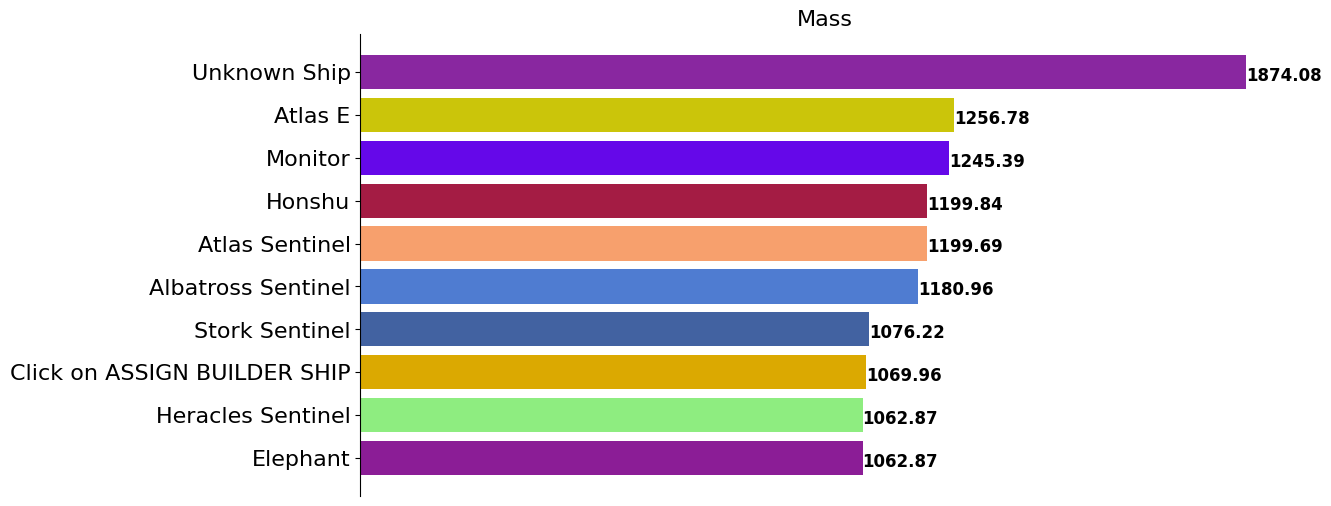

In [101]:
plot_data_1 = all_ships[['name','ship_mass']].sort_values(by = ['ship_mass'], ascending = False).head(10)
color_list = []
for x in range(len(plot_data_1.index)):
    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])][0]
    color_list.append(color)
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot()
ax.barh( plot_data_1['name'][::-1], plot_data_1['ship_mass'][::-1], color = color_list)
#Оформление
ax.set_title('Mass',size=16) 
ax.tick_params(axis='both',labelsize=16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.axes.get_xaxis().set_visible(False)
#Надписи
rects = ax.patches
for bar in rects:   
        width = bar.get_width()    
        ax.text(width, bar.get_y()+0.2, str(round(width, 2)),fontsize='12', weight='bold', color='black') 
plt.show()

### Forward drag <a class="anchor" id="id_3b"></a>

In [102]:
plot_data_2 = all_ships[['name','drag_forward','purpose']].sort_values(by = ['drag_forward'], ascending = False)
display(plot_data_2.head(10))

,name,drag_forward,purpose
220,Unknown Ship,454.817,fight
216,Stork Sentinel,369.055,auxiliary
215,Stork Vanguard,324.213,auxiliary
212,Albatross Sentinel,316.193,build
214,Condor Sentinel,310.771,fight
204,Atlas E,310.646,auxiliary
203,Atlas Sentinel,299.941,auxiliary
195,Click on ASSIGN BUILDER SHIP,293.991,auxiliary
191,Equatorial latitudes enjoy a temperate,292.574,build
198,Heracles Sentinel,292.574,build


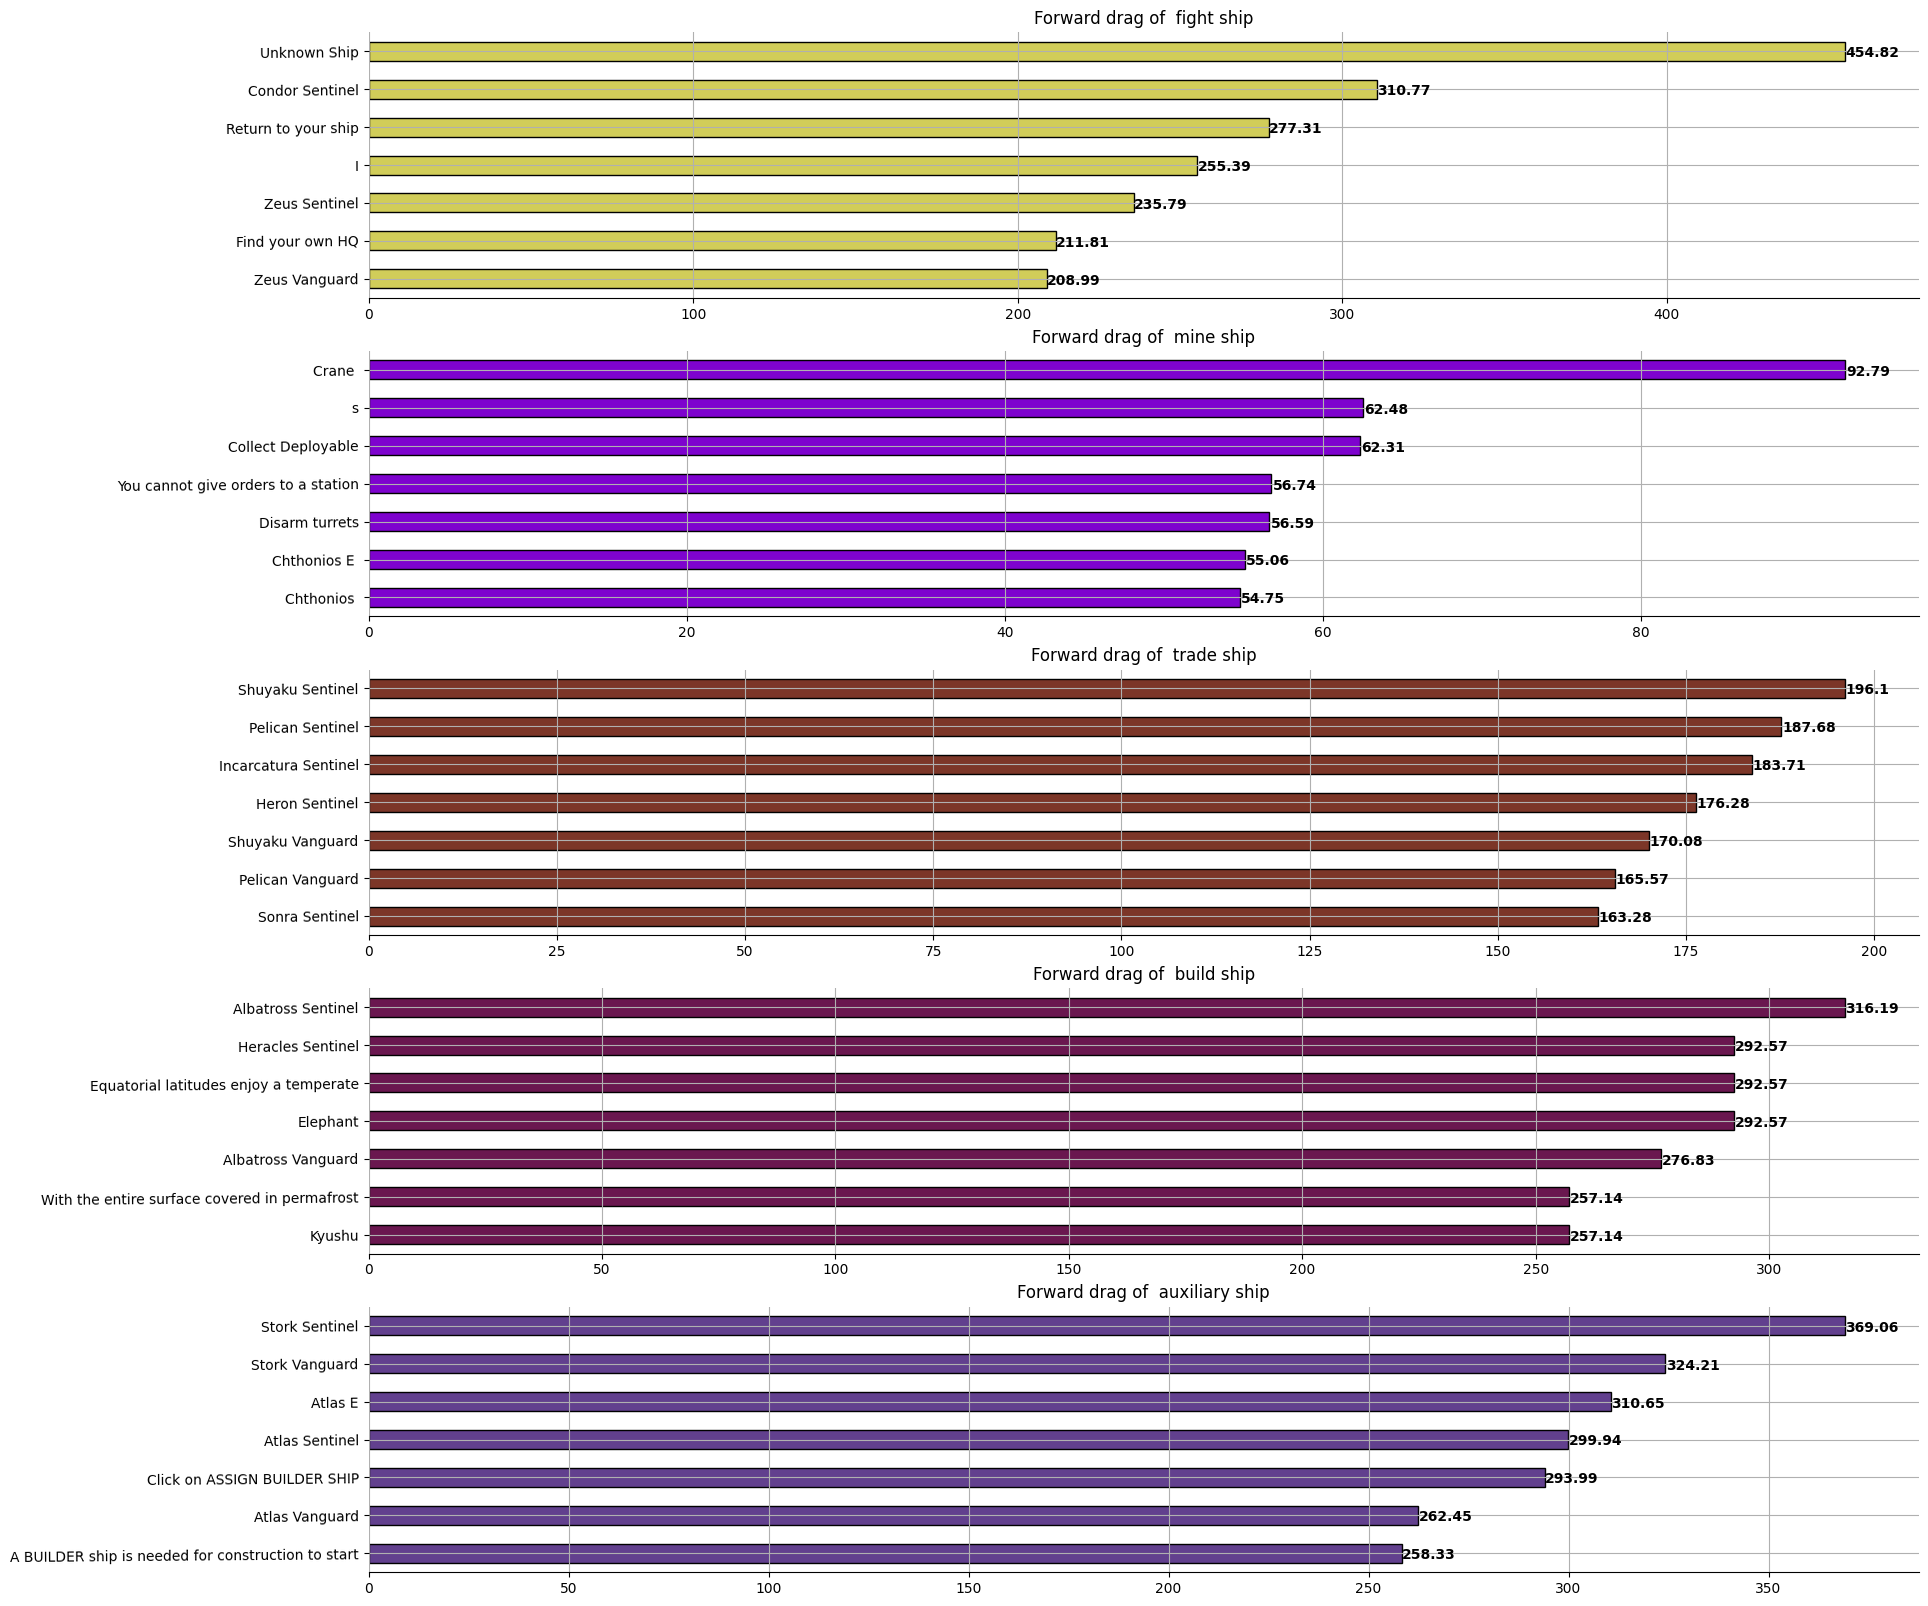

In [103]:
cols = 1 # число колонок под вложенные графики
rows = 5 # число строчек под вложенные графики
count = 0
#Список предназначений кораблей
purposes = ['fight', 'mine', 'trade', 'build', 'auxiliary']
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20,20))
for r in range(rows):                
            color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
            axes[r] = plot_data_2[plot_data_2['purpose']==purposes[count]].pivot_table(
                index = ['name'],
                values = ['drag_forward'],
                aggfunc = 'first').sort_values(by = ['drag_forward'],ascending = True).tail(7).plot(  kind='barh',
                                                      ax = axes[r], 
                                                      edgecolor='black', 
                                                      color = color, grid=True,
                                                      title = f'Forward drag of  {purposes[count]} ship', xlabel = '', ylabel = '',
                                                      legend=False, rot = 0.45)
            #Убирание рамок вложенных графиков
            axes[r].spines['top'].set_visible(False)
            axes[r].spines['right'].set_visible(False)
            axes[r].spines['left'].set_visible(False)  
            #Нанесение значений            
            rects = axes[r].patches          
            for index in range(len(rects)):
                width = rects[index].get_width()
                t = axes[r].text(width+0.1, rects[index].get_y()+0.2, str(round(width, 2)),
                          fontsize='medium', weight='bold', color='black',va='center',ha='left')
            count+=1
plt.subplots_adjust(hspace=0.2,wspace=0.2)
plt.show()

### Прочность корпуса корабля <a class="anchor" id="id_3c"></a>

In [104]:
plot_data_3 = all_ships[['name','hull','purpose','ship_type']]
display(plot_data_3.head(2))

,name,hull,purpose,ship_type
0,L Ship,93000,fight,destroyer
1,XL Ship,111000,fight,destroyer


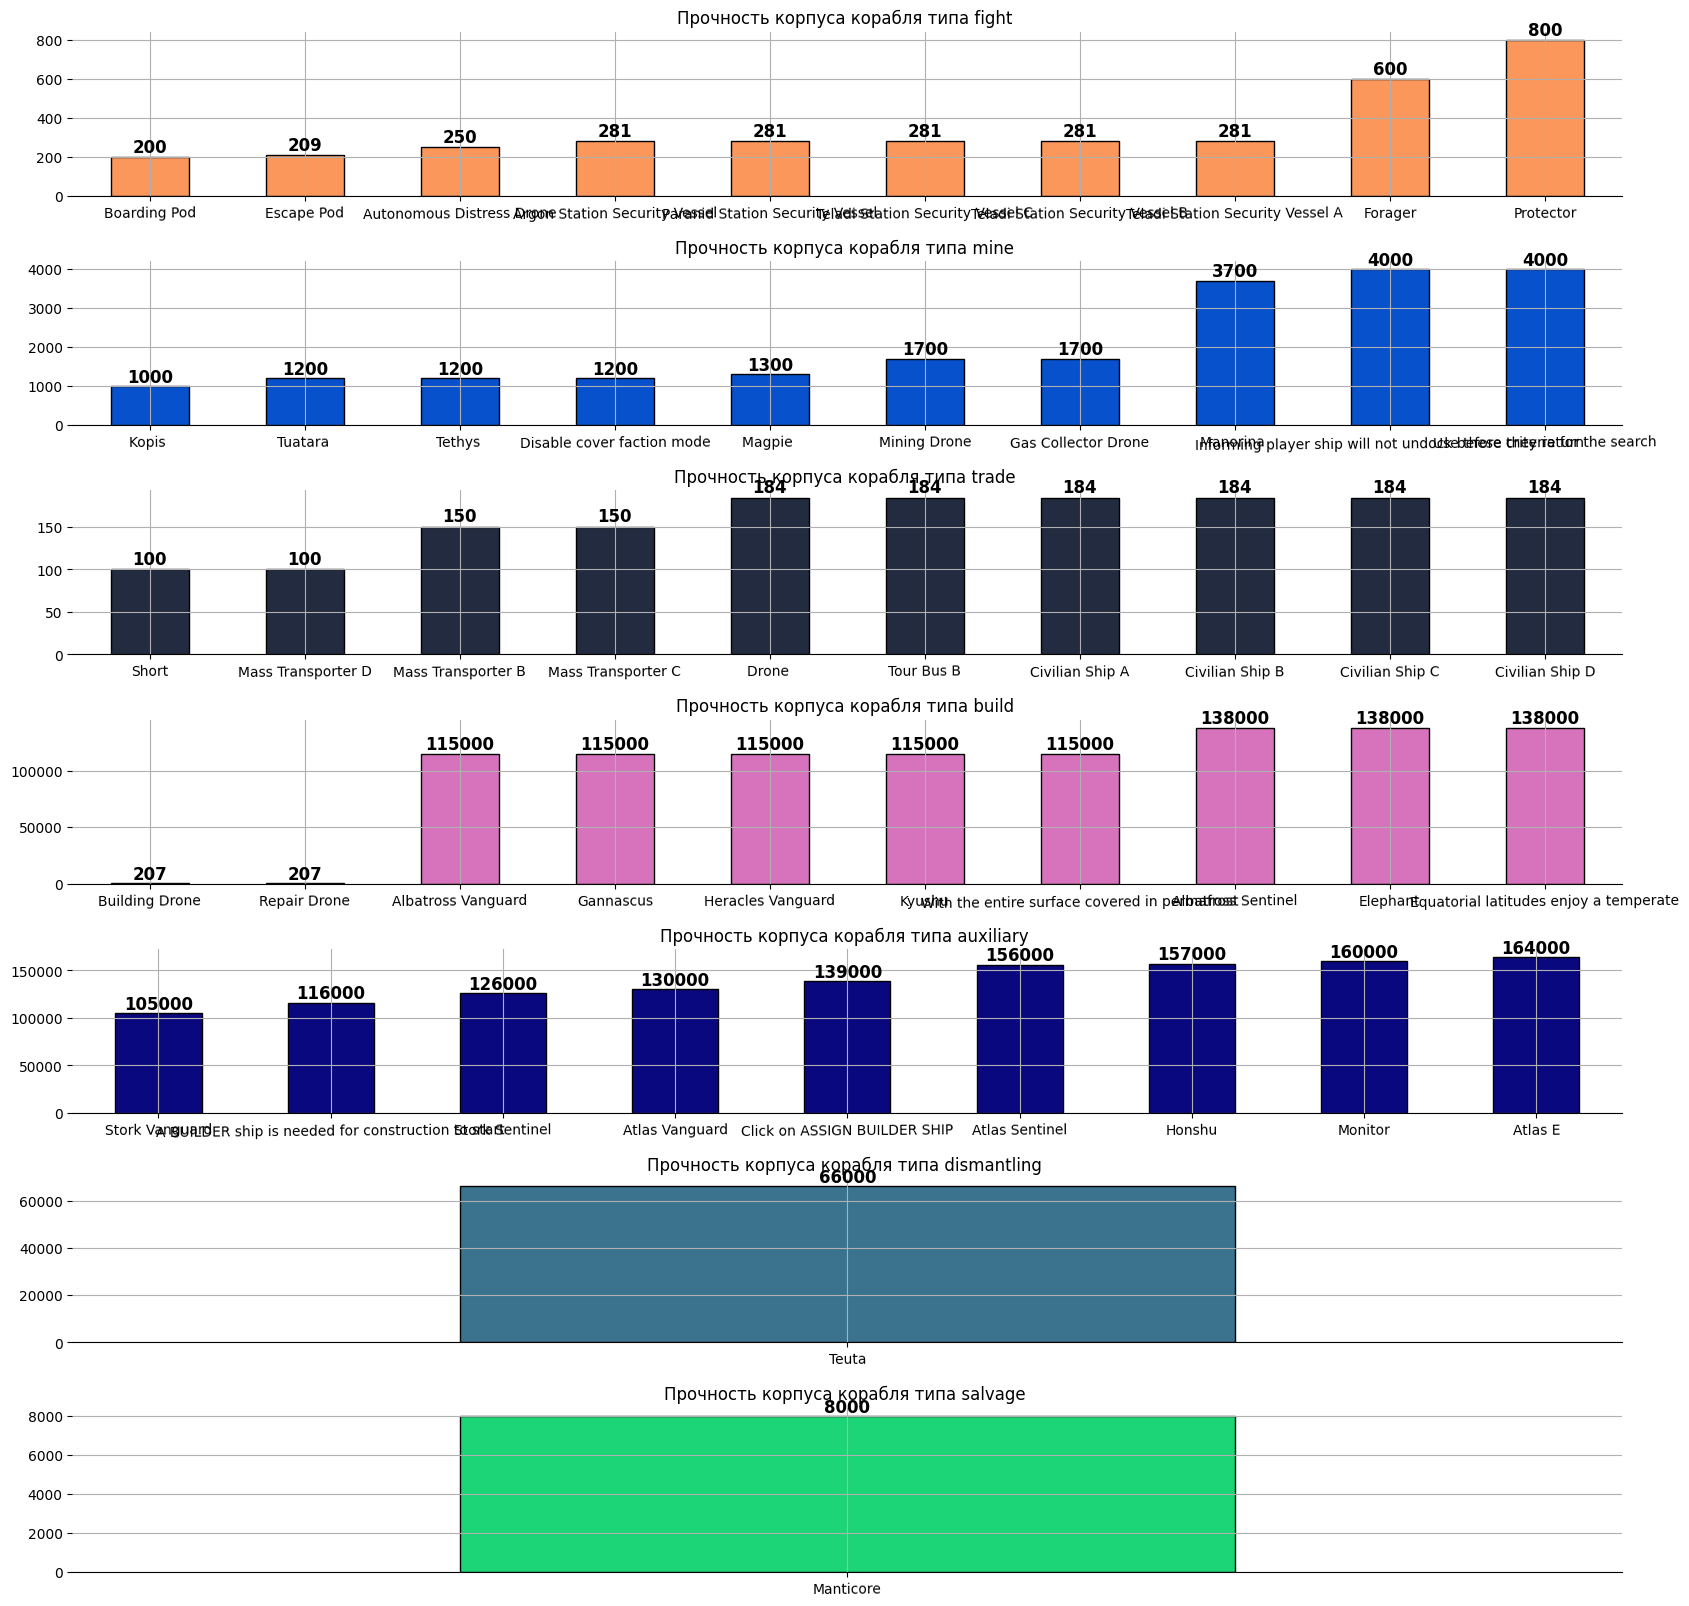

In [105]:
purposes = plot_data_3['purpose'].unique() # список назначений корабля
cols = 1 # число колонок под вложенные графики
rows = len(plot_data_3['purpose'].unique()) # число строчек под вложенные графики
count = 0 # counter

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20,20))
for r in range(rows):                
            color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])] # color generator
            axes[r] = plot_data_3[plot_data_3['purpose']==purposes[count]].pivot_table(
                  index = ['name'],
                  values = ['hull'],
                  aggfunc ='first' ).sort_values(by = ['hull']).head(10).plot(
                kind='bar', ax = axes[r], edgecolor='black',  color = color, grid=True,
                title = f'Прочность корпуса корабля типа {purposes[count]} ', xlabel = '', legend=False, rot = 0.45)
            
            #Убирание рамок вложенных графиков
            axes[r].spines['top'].set_visible(False)
            axes[r].spines['right'].set_visible(False)
            axes[r].spines['left'].set_visible(False)  
            
            #Нанесение значений
            rects = axes[r].patches
            for rect in rects:
                    height = rect.get_height()    
                    axes[r].text(rect.get_x() + rect.get_width() / 2, height + 2, round(height,1),
                          ha="center", va="bottom",weight='bold',size='large',c='black')            
            count+=1
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

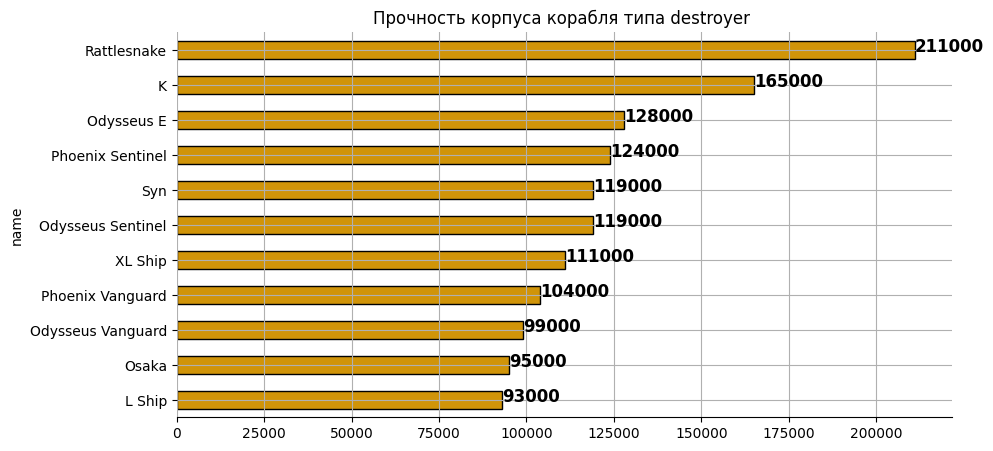

In [106]:
purposes = plot_data_3['purpose'].unique() # список назначений корабля
cols = 1 # число колонок под вложенные графики
#rows = len(plot_data_3[('purpose','')].unique()) # число строчек под вложенные графики
count = 0 # counter
rows = 1
fig = plt.figure(figsize=(10,5))
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])] # color generator
ax = fig.add_subplot()
ax = plot_data_3[(plot_data_3['purpose']=='fight')
                                  & (plot_data_3['ship_type']=='destroyer')].pivot_table(
                  index = ['name'],
                  values = ['hull'],
                  aggfunc ='first' ).sort_values(by = ['hull']).plot(
                kind='barh', ax = ax, edgecolor='black',  color = color, grid=True,
                title = f'Прочность корпуса корабля типа destroyer ', xlabel = '', legend=False)
            
            #Убирание рамок вложенных графиков
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)  
#Надписи
rects = ax.patches
for bar in rects:   
        width = bar.get_width()    
        ax.text(width, bar.get_y()+0.2, str(round(width, 2)),fontsize='12', weight='bold', color='black') 
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

In [107]:
display(all_ships['ship_type'].unique())

array(['destroyer', 'scavenger', 'gunboat', 'frigate', 'heavyfighter',
       'corvette', 'fighter', 'scout', 'smalldrone', 'lasertower',
       'carrier', 'battleship', 'police', 'unknown', 'distressdrone',
       'escapepod', 'largeminer', 'miner', 'freighter', 'transporter',
       'courier', 'personalvehicle', 'xsdrone', 'builder', 'resupplier',
       'compactor', 'tug'], dtype=object)

In [108]:
plot_data_4 = all_ships[all_ships['ship_type']=='frigate'].groupby('name')['hull'].max()
display([plot_data_4])


[name
 Cerberus Sentinel    20000
 Cobra                32000
 Falx                 20000
 Gorgon Sentinel      23000
 Gorgon Vanguard      19000
 Osprey Sentinel      39000
 Osprey Vanguard      33000
 plea                 17000
 Name: hull, dtype: int32]

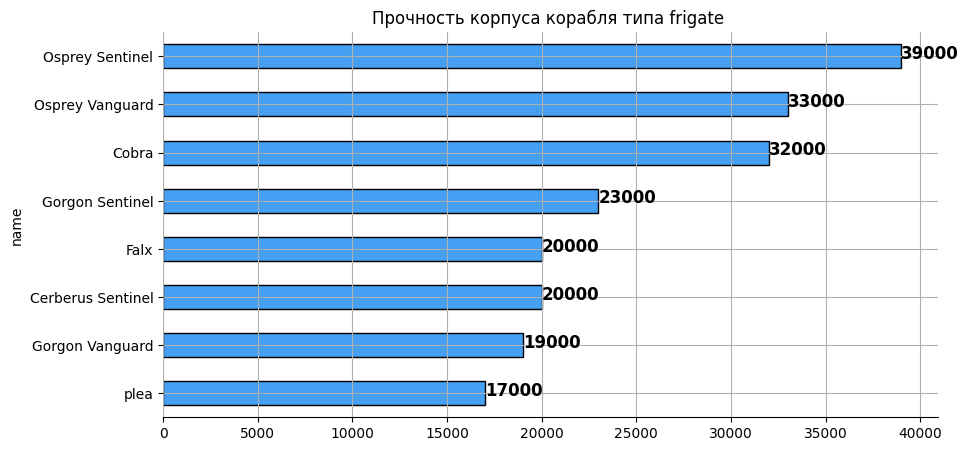

In [109]:
plot_data_4 = all_ships[all_ships['ship_type']=='frigate'].groupby('name')['hull'].max().sort_values()
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
ax = plot_data_4.plot(
                kind='barh', ax = ax, edgecolor='black',  color = color, grid=True,
                title = f'Прочность корпуса корабля типа frigate ', xlabel = '', legend=False)
            
            #Убирание рамок вложенных графиков
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)  
#Надписи
rects = ax.patches
for bar in rects:   
        width = bar.get_width()    
        ax.text(width, bar.get_y()+0.2, str(round(width, 2)),fontsize='12', weight='bold', color='black') 
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

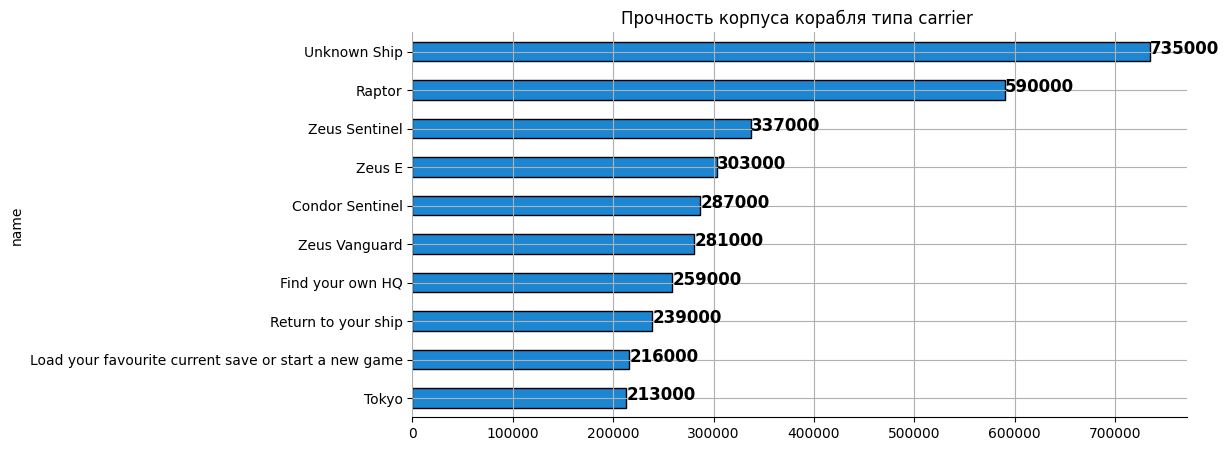

In [110]:
plot_data_5 = all_ships[all_ships['ship_type']=='carrier'].groupby('name')['hull'].max().sort_values()
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
ax = plot_data_5.plot(
                kind='barh', ax = ax, edgecolor='black',  color = color, grid=True,
                title = f'Прочность корпуса корабля типа carrier ', xlabel = '', legend=False)
            
            #Убирание рамок вложенных графиков
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)  
#Надписи
rects = ax.patches
for bar in rects:   
        width = bar.get_width()    
        ax.text(width, bar.get_y()+0.2, str(round(width, 2)),fontsize='12', weight='bold', color='black') 
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

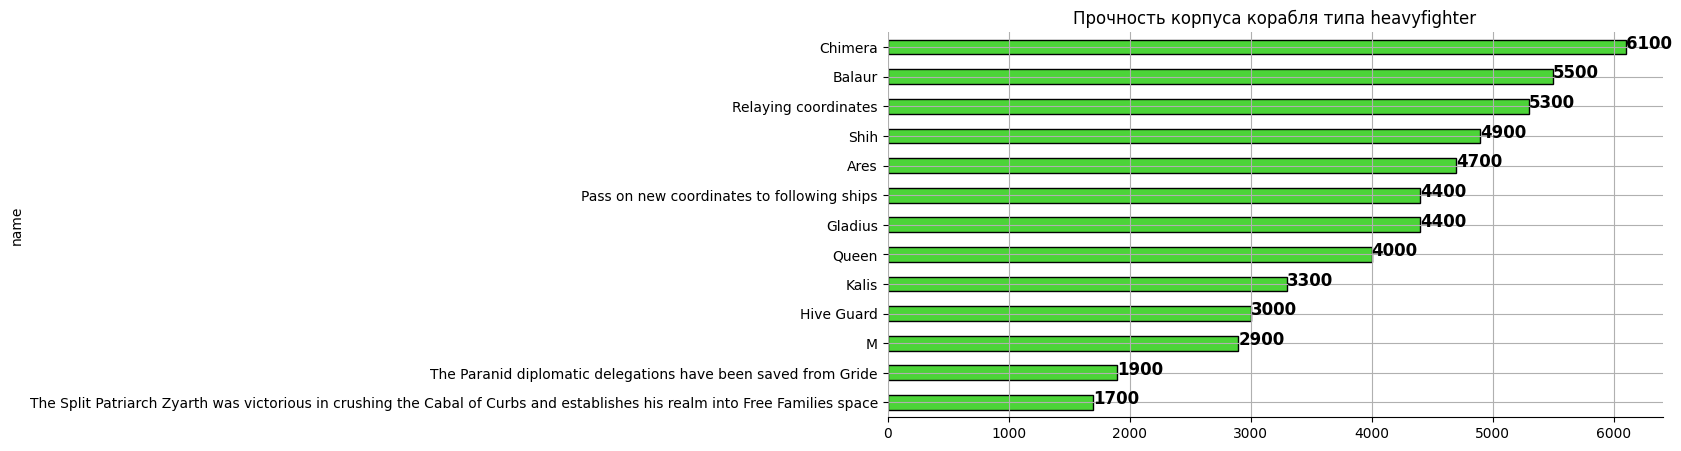

In [111]:
plot_data_6 = all_ships[all_ships['ship_type']=='heavyfighter'].groupby('name')['hull'].max().sort_values()
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
ax = plot_data_6.plot(
                kind='barh', ax = ax, edgecolor='black',  color = color, grid=True,
                title = f'Прочность корпуса корабля типа heavyfighter', xlabel = '', legend=False)
            
            #Убирание рамок вложенных графиков
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)  
#Надписи
rects = ax.patches
for bar in rects:   
        width = bar.get_width()    
        ax.text(width, bar.get_y()+0.2, str(round(width, 2)),fontsize='12', weight='bold', color='black') 
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

### Что нужно сделать:

2. Вычистить мусор из таблиц.
3. Привести имена кораблей в порядок
4. Рассчитать рейтинг маневренности корабля на основе его летательных характеристик
5. Присвоить ранги кораблям
6. Найти в данных информацию по секторам и запасам ресурсов в них.